<a href="https://colab.research.google.com/github/Naglaa-elmesalmy/Data-science-by-python/blob/main/final_model_face_emotion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print(tf.__version__)

NameError: ignored

In [ ]:


import os
import warnings
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.python.lib.io import file_io
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.metrics import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator , img_to_array, load_img
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, ZeroPadding2D, Convolution2D,Layer ,Dropout, BatchNormalization, LeakyReLU, Activation
from keras.models import Model
from keras.models import load_model
from keras.callbacks import ModelCheckpoint
from keras.utils import np_utils
import keras.backend as K
from keras import regularizers
from tensorflow.keras.utils import plot_model
from keras.losses import categorical_crossentropy
from skimage.transform import rescale, resize
import seaborn as sns
import cv2
#from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix,classification_report
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# perpare data

### 1- augmantion

In [ ]:
# names of folders
dirLst=["angry","diagust","fear","happy","neutral","sad","surprise"]
# ImageDataGenerator accepts the original data, randomly transforms it, and returns only the new, transformed data
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
#loop on folder and images
for fdr in dirLst:
    path=r".\test_crop"
    img_fdr=os.path.join(path,fdr)
    for img_path in os.listdir(img_fdr):
        img = load_img(os.path.join(img_fdr,img_path))  # this is a PIL image
        x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
        x = x.reshape((1,) + x.shape)
        i = 0
        # transfer each image to 20 images with  randomly transforms and save it on same folder with perfix the name of folder
        for batch in datagen.flow(x, batch_size=1,save_to_dir=img_fdr, save_prefix=fdr, save_format='jpeg'):
            i += 1
            if i > 20:
                break


### 2- convert our images to dataset

In [ ]:
def convert_image_to_dataset(folderpath,i):
    X = pd.DataFrame([])
    Y = pd.DataFrame([])
    for img in os.listdir(folderpath):
        img_array = cv2.imread(os.path.join(folderpath,img), cv2.IMREAD_GRAYSCALE)
        img_pil = Image.fromarray(img_array)
        img_48x48 = np.array(img_pil.resize((48, 48), Image.ANTIALIAS))
        img_array = (img_48x48.flatten())
        X = X.append(pd.DataFrame([[img_array]],columns=['pixels']), ignore_index=True)

    Y=pd.DataFrame(i, index=range(X.shape[0]), columns=['emotion'])


    return  X, Y

In [ ]:
import pandas as pd
path =('/content/drive/My Drive/test_crop_aug/test_crop')
emotion_mapping = {0: 'angry', 1: 'diagust', 2: 'fear', 3: 'happy', 4: 'sad', 5: 'surprise', 6: 'neutral'}
for k, v in emotion_mapping.items():
    x,y = convert_image_to_dataset(path+'/'+v,k)
    X_train, X_test, y_train, y_test = train_test_split(x,y, test_size=0.33,shuffle=True, random_state=42)
    X_train, X_val, y_train, y_val=train_test_split(X_train,y_train, test_size=0.33,shuffle=True, random_state=42)
    if k==0 :
        X_train_All=X_train
        X_val_All=X_val
        X_test_All=X_test
        y_train_All=y_train
        y_val_All=y_val
        y_test_All=y_test
    else :
        X_train_All=pd.concat([X_train_All, X_train])
        X_val_All=pd.concat([X_val_All,X_val])
        X_test_All=pd.concat([X_test_All, X_test])
        y_train_All=pd.concat([y_train_All, y_train])
        y_val_All=pd.concat([y_val_All,y_val])
        y_test_All=pd.concat([y_test_All, y_test])

In [ ]:
X_train_All

,pixels
62,"[145, 132, 111, 90, 82, 95, 122, 144, 142, 133..."
94,"[113, 111, 110, 112, 116, 121, 124, 125, 130, ..."
71,"[220, 219, 219, 219, 219, 220, 221, 222, 222, ..."
90,"[22, 24, 25, 23, 22, 24, 31, 36, 31, 30, 31, 3..."
0,"[186, 164, 143, 130, 106, 83, 94, 123, 143, 14..."
...,...
8,"[152, 155, 159, 162, 163, 164, 165, 165, 170, ..."
67,"[41, 29, 39, 9, 23, 63, 31, 15, 23, 20, 20, 24..."
369,"[230, 237, 188, 111, 71, 55, 41, 38, 45, 40, 3..."
149,"[171, 171, 169, 167, 167, 169, 168, 166, 167, ..."


In [ ]:
X_train_All = np.array(X_train_All['pixels'].tolist(), dtype='float32').reshape(-1,48,48,1)
X_val_All = np.array(X_val_All['pixels'].tolist(), dtype='float32').reshape(-1,48,48,1)
X_test_All = np.array(X_test_All['pixels'].tolist(), dtype='float32').reshape(-1,48,48,1)
X_train_All = X_train_All/255.0
X_val_All = X_val_All/255.0
X_test_All = X_test_All/255.0
y_train_All=np_utils.to_categorical(y_train_All, 7)
y_val_All=np_utils.to_categorical(y_val_All, 7)
y_test_All=np_utils.to_categorical(y_test_All, 7)

In [ ]:
y_test_All.shape

(581, 7)

In [ ]:
y_test_All

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

### 3- load fer2013

In [ ]:
data = pd.read_csv('/content/drive/My Drive/nglamodel/fer2013.csv')
train_fer2013 = data#[(data['Usage'] == 'Training')]
val_fer2013 = data[(data['Usage'] == 'PrivateTest')]
test_fer2013 = data[(data['Usage'] == 'PublicTest')]
x_train_fer2013 = np.array(list(map(str.split, train_fer2013.pixels)), np.float32)
x_val_fer2013 = np.array(list(map(str.split, val_fer2013.pixels)), np.float32)
x_test_fer2013 = np.array(list(map(str.split, test_fer2013.pixels)), np.float32)
x_train_fer2013 = x_train_fer2013.reshape(x_train_fer2013.shape[0], 48, 48, 1)
x_val_fer2013 = x_val_fer2013.reshape(x_val_fer2013.shape[0], 48, 48, 1)
x_test_fer2013 = x_test_fer2013.reshape(x_test_fer2013.shape[0], 48, 48, 1)
x_train_fer2013=x_train_fer2013/255
x_val_fer2013=x_val_fer2013/255
x_test_fer2013=x_test_fer2013/255
y_train_fer2013 = train_fer2013['emotion']
y_val_fer2013 = val_fer2013['emotion']
y_test_fer2013 = test_fer2013['emotion']
y_train_fer2013 = np_utils.to_categorical(y_train_fer2013, 7)
y_val_fer2013 = np_utils.to_categorical(y_val_fer2013, 7)
y_test_fer2013 = np_utils.to_categorical(y_test_fer2013, 7)

In [ ]:
#y_train_fer2013 = train_fer2013['emotion']
y_val_fer2013.shape

(3589, 7)

### 4- merge our image with fer2013

In [ ]:
X_train_All=np.vstack([X_train_All, x_train_fer2013])
X_val_All=np.vstack([X_val_All, x_val_fer2013])
X_test_All=np.vstack([X_test_All, x_test_fer2013])
y_train_All=np.vstack([y_train_All, y_train_fer2013])
y_val_All=np.vstack([y_val_All, y_val_fer2013])
y_test_All=np.vstack([y_test_All, y_test_fer2013])

# Our model

### 1- attention layer

In [ ]:
# Add attention layer to the deep learning network
class attention(Layer):
    def __init__(self,**kwargs):
        super(attention,self).__init__(**kwargs)

    def build(self,input_shape):
        self.W=self.add_weight(name='attention_weight', shape=(input_shape[-1],1),
                               initializer='random_normal', trainable=True)
        self.b=self.add_weight(name='attention_bias', shape=(input_shape[1],1),
                               initializer='zeros', trainable=True)
        super(attention, self).build(input_shape)

    def call(self,x):
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        # Remove dimension of size 1
        e = K.squeeze(e, axis=-1)
        # Compute the weights
        alpha = K.softmax(e)
        # Reshape to tensorFlow format
        alpha = K.expand_dims(alpha, axis=-1)
        # Compute the context vector
        context = x * alpha
        context = K.sum(context, axis=1)
        return context

### 2- create our model

In [ ]:
np.random.seed(1)
tf.random.set_seed(1)

model1 = Sequential()


model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same', input_shape=(48,48,1)))
model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.30))
model1.add(BatchNormalization())

model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(Conv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.30))
model1.add(BatchNormalization())

model1.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same',kernel_regularizer=regularizers.l2(0.0001)))
model1.add(Conv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.30))
model1.add(BatchNormalization())

model1.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same',kernel_regularizer=regularizers.l2(0.0001)))
model1.add(Conv2D(1024, (3,3), activation = 'relu', padding = 'same'))
model1.add(MaxPooling2D(2,2))
model1.add(Dropout(0.30))

model1.add(attention())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(0.35))

model1.add(BatchNormalization())
model1.add(Flatten())
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.35))

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.35))
model1.add(BatchNormalization())

model1.add(Dense(7, activation='softmax'))

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 128)       1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 128)       147584    
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 24, 24, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 128)       1

### 3- save best weights and draw livelossplot

In [ ]:
%pip install livelossplot
from livelossplot.inputs.keras import PlotLossesCallback
plot_loss_1 = PlotLossesCallback()
# ModelCheckpoint callback - save best weights
tl_checkpoint_2 =ModelCheckpoint(filepath='/content/drive/MyDrive/nglamodel/tl_model_v2.weights.best.hdf5',
                                 monitor='val_acc', verbose=1, save_weights_only=False,
                                 save_best_only=False, mode='max')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 42.9 MB/s 


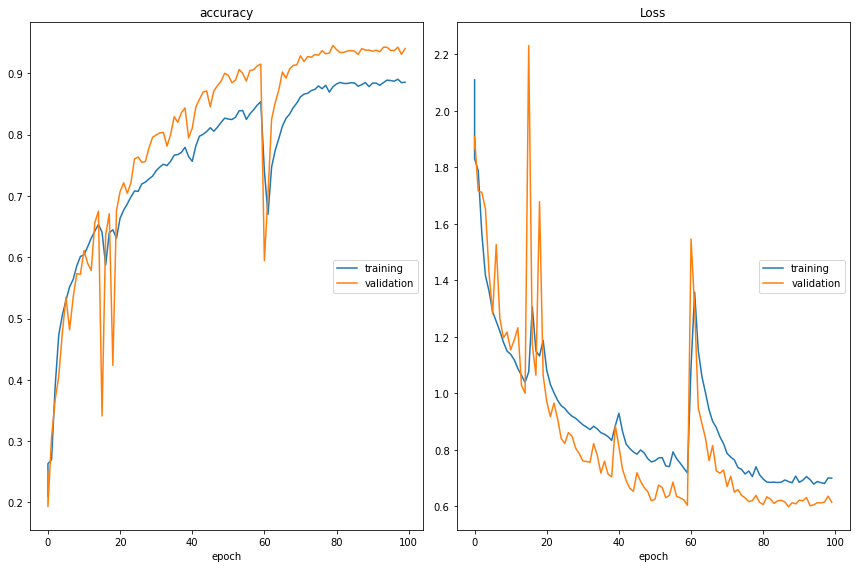

accuracy
	training         	 (min:    0.210, max:    0.890, cur:    0.885)
	validation       	 (min:    0.193, max:    0.945, cur:    0.940)
Loss
	training         	 (min:    0.679, max:    2.109, cur:    0.700)
	validation       	 (min:    0.599, max:    2.231, cur:    0.614)
366/366 [==============================] - 25s 68ms/step - loss: 0.7002 - accuracy: 0.8855 - val_loss: 0.6144 - val_accuracy: 0.9404


In [ ]:
optimizer = Adam(learning_rate=0.001)
BATCH_SIZE = 100
model1.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
h1 = model1.fit(
        X_train_All, y_train_All,
        steps_per_epoch=len(X_train_All) // BATCH_SIZE,
        validation_data=(X_val_All, y_val_All),
        validation_steps=len(X_val_All) // BATCH_SIZE,
        callbacks=[tl_checkpoint_2,  plot_loss_1],
        epochs=100
    )

In [ ]:
from keras.models import load_model
model1.save("/content/drive/MyDrive/the_final_model_v2.h5")
loaded_model = load_model("/content/drive/MyDrive/the_final_model_v2.h5", custom_objects={"attention": attention})
#train accuracy
loss, accuracy = loaded_model.evaluate(X_train_All,y_train_All)
#test accuracy
loss, accuracy = loaded_model.evaluate(X_test_All,y_test_All)


131/131 [==============================] - 2s 17ms/step - loss: 0.6372 - accuracy: 0.9321


# Result

In [ ]:
preds = loaded_model.predict(X_test_All)
y_pred = np.argmax(preds , axis = 1 )

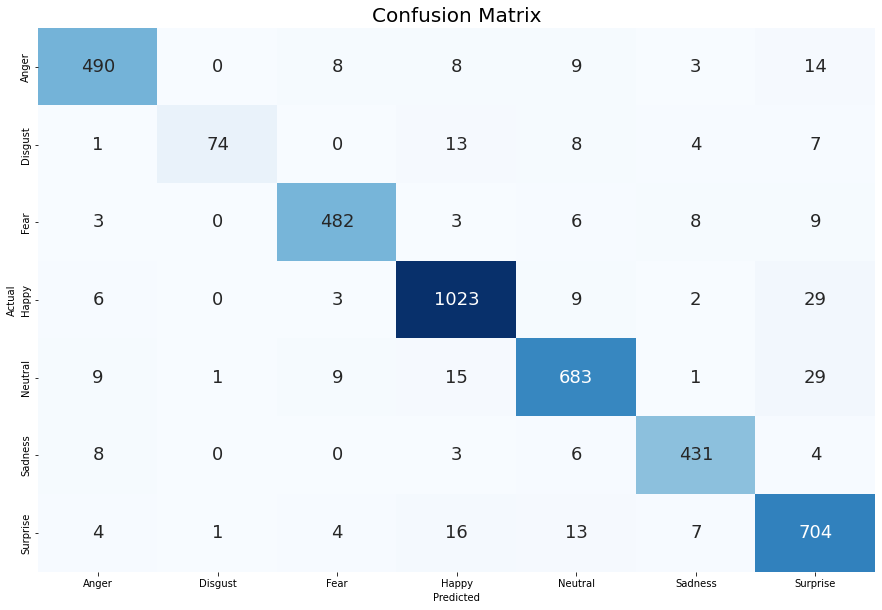

In [ ]:
CLASS_LABELS  = ['Anger', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sadness', "Surprise"]

cm_data = confusion_matrix(np.argmax(y_test_All, axis = 1 ), y_pred)
cm = pd.DataFrame(cm_data, columns=CLASS_LABELS, index = CLASS_LABELS)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (15,10))
plt.title('Confusion Matrix', fontsize = 20)
sns.set(font_scale=1.2)
ax = sns.heatmap(cm, cbar=False, cmap="Blues", annot=True, annot_kws={"size": 18}, fmt='g')

In [ ]:
print('testing report :','\n',classification_report(np.argmax(y_test_All, axis = 1 ),y_pred,digits=3))

testing report : 
               precision    recall  f1-score   support

           0      0.940     0.921     0.931       532
           1      0.974     0.692     0.809       107
           2      0.953     0.943     0.948       511
           3      0.946     0.954     0.950      1072
           4      0.931     0.914     0.922       747
           5      0.945     0.954     0.949       452
           6      0.884     0.940     0.911       749

    accuracy                          0.932      4170
   macro avg      0.939     0.903     0.917      4170
weighted avg      0.933     0.932     0.932      4170

